In [1]:
import numpy as np
import pandas as pd
import random
import sklearn
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")


In [2]:
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

# age：年龄
bp：blood_pressure，血压
sg：specific_gravity，比重值；肾脏疾病通常是检测尿比重
al：albumin，白蛋白
su：sugar，葡萄糖
rbc：red_blood_cells，【红血细胞】是否正常？
pc：pus_cell，【脓细胞】含量是否正常？
pcc：pus_cell_clumps，【脓细胞群】是否正常
ba：bacteria，是否【细菌】感染？
bgr：blood_glucose_random，随机血糖量
bu：blood_urea，血尿素
sc：serum_creatinine，血清肌酐
sod：sodium，钠
pot：potassium，钾
hemo：haemoglobin，血红蛋白
pcv：packed_cell_volume（PCV），血细胞压积，红细胞在血液中所占容积比
wc：white_blood_cell_count，白血细胞计数
rc：red_blood_cell_count，红血细胞计数
htn：hypertension，是否有【高血压】？
dm：diabetes_mellitus，是否有【糖尿病】？
cad：coronary_artery_disease，是否有【冠状动脉疾病】？
appet：appetite，是否有【食欲】？
pe：peda_edema，足部是否【水肿】？
ane：aanemia，是否【贫血】？
classification：分类结果，是否患病

In [3]:
data = pd.read_csv('ckd_training.csv')

missing_rows = data[data.isnull().any(axis=1)]
num_missing_rows = len(missing_rows)

print("Number of rows with missing values:", num_missing_rows)

Number of rows with missing values: 0


In [4]:
# 数据类型
data.dtypes

age      float64
bp         int64
sg         int64
al       float64
su       float64
rbc      float64
pc       float64
pcc        int64
ba         int64
bgr      float64
bu       float64
sc       float64
sod      float64
pot      float64
hemo     float64
pcv      float64
wbcc       int64
rbcc     float64
htn      float64
dm       float64
cad      float64
appet    float64
pe       float64
ane        int64
class      int64
dtype: object

In [5]:
# 缺失值统计
data.isnull().sum()

age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64

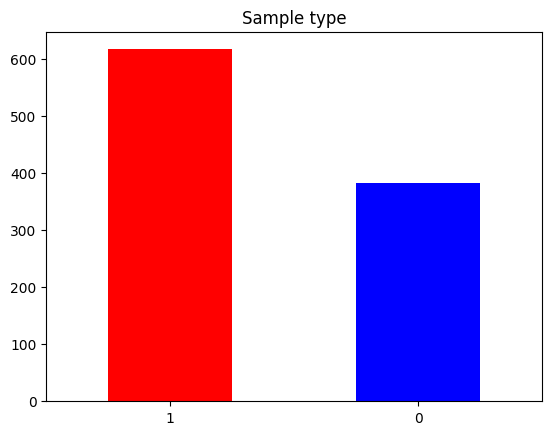

In [6]:
# 对class进行直观可视化
data['class'].value_counts().plot(kind='bar', color=['r', 'b'],
                                  title="Sample type")
plt.xticks(rotation=0)
plt.show()

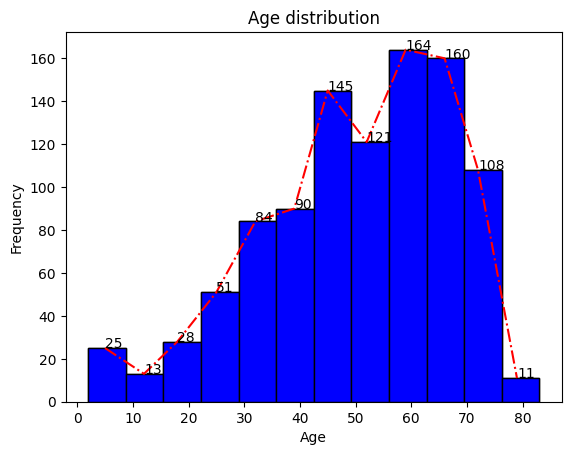

In [7]:
# 绘制年龄分布的直方图
plt.hist(data['age'], bins=12, edgecolor='black', color='b')
text = plt.hist(data['age'], bins=12, edgecolor='black', color='b')
y = list(int(i) for i in text[:][0])
x = list(text[:][1])
x = list(int((x[i] + x[i - 1]) / 2) for i in range(len(x)) if i >= 1)
# 绘制折线图
plt.plot(x, y, 'r-.', linewidth=1.5)
for i in range(len(x)):
    plt.text(x[i], y[i], f'{y[i]}')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age distribution')
plt.show()

In [8]:
ori_data = data.iloc[:, :-1]
df = pd.DataFrame(ori_data, columns=data.columns[:-1])
df['class'] = [int(k) for k in data['class']]
# round
columns_to_convert = ["age", "bp", "al", "su", "rbc", "pc", "pcc", "ba", "bgr", "bu", "sod", "pcv", "wbcc", "htn", "dm",
                      "cad", "appet", "pe", "ane"]
for item in columns_to_convert:
    df[item] = [round(k) for k in df[item]]


print(df.isnull().sum())


age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64


In [9]:
ori_data

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,60.0,70,1,0.0,0.0,0.4,1.0,0,0,140.0,...,13.4,39.0,9460,4.9,0.0,0.0,0.0,1.0,0.0,0
1,64.0,90,1,3.0,3.0,0.4,0.0,1,0,229.4,...,10.3,36.0,9720,4.5,1.0,1.0,0.0,1.0,1.0,0
2,65.0,70,1,0.0,0.0,0.4,1.0,0,0,93.0,...,11.6,36.0,11900,3.9,0.0,1.0,0.0,1.0,0.0,0
3,42.0,100,1,4.0,0.0,1.0,0.0,0,1,220.0,...,11.1,39.0,8300,4.6,1.0,0.0,0.0,0.0,0.0,0
4,65.0,70,1,1.0,0.0,0.0,1.0,0,0,203.0,...,11.4,36.0,5000,4.1,1.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33.0,80,1,0.0,0.0,1.0,1.0,0,0,100.0,...,16.9,52.0,6700,6.0,0.0,0.0,0.0,1.0,0.0,0
996,14.0,70,1,0.0,0.0,0.4,0.6,0,0,192.0,...,14.3,40.0,9500,5.4,0.0,1.0,0.0,0.0,1.0,0
997,55.0,80,1,0.0,0.0,1.0,1.0,0,0,118.0,...,15.5,43.0,7200,5.4,0.0,0.0,0.0,1.0,0.0,0
998,24.0,66,1,2.0,4.0,1.0,0.0,0,0,410.0,...,12.4,44.0,6900,5.0,0.0,1.0,0.0,1.0,1.0,0


In [10]:
print(df.dtypes)

age        int64
bp         int64
sg         int64
al         int64
su         int64
rbc        int64
pc         int64
pcc        int64
ba         int64
bgr        int64
bu         int64
sc       float64
sod        int64
pot      float64
hemo     float64
pcv        int64
wbcc       int64
rbcc     float64
htn        int64
dm         int64
cad        int64
appet      int64
pe         int64
ane        int64
class      int64
dtype: object


In [11]:
df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,60,70,1,0,0,0,1,0,0,140,...,39,9460,4.9,0,0,0,1,0,0,1
1,64,90,1,3,3,0,0,1,0,229,...,36,9720,4.5,1,1,0,1,1,0,1
2,65,70,1,0,0,0,1,0,0,93,...,36,11900,3.9,0,1,0,1,0,0,1
3,42,100,1,4,0,1,0,0,1,220,...,39,8300,4.6,1,0,0,0,0,0,1
4,65,70,1,1,0,0,1,0,0,203,...,36,5000,4.1,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33,80,1,0,0,1,1,0,0,100,...,52,6700,6.0,0,0,0,1,0,0,0
996,14,70,1,0,0,0,1,0,0,192,...,40,9500,5.4,0,1,0,0,1,0,1
997,55,80,1,0,0,1,1,0,0,118,...,43,7200,5.4,0,0,0,1,0,0,0
998,24,66,1,2,4,1,0,0,0,410,...,44,6900,5.0,0,1,0,1,1,0,1


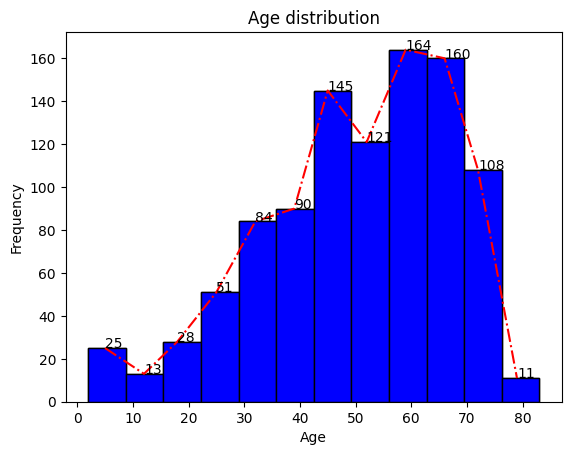

In [12]:
# 绘制年龄分布的直方图
plt.hist(data['age'], bins=12, edgecolor='black', color='b')
text = plt.hist(data['age'], bins=12, edgecolor='black', color='b')
y = list(int(i) for i in text[:][0])
x = list(text[:][1])
x = list(int((x[i] + x[i - 1]) / 2) for i in range(len(x)) if i >= 1)
# 绘制折线图
plt.plot(x, y, 'r-.', linewidth=1.5)
for i in range(len(x)):
    plt.text(x[i], y[i], f'{y[i]}')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age distribution')
plt.show()

In [13]:
df.dtypes

age        int64
bp         int64
sg         int64
al         int64
su         int64
rbc        int64
pc         int64
pcc        int64
ba         int64
bgr        int64
bu         int64
sc       float64
sod        int64
pot      float64
hemo     float64
pcv        int64
wbcc       int64
rbcc     float64
htn        int64
dm         int64
cad        int64
appet      int64
pe         int64
ane        int64
class      int64
dtype: object

In [14]:
# 分类型
cat_cols = [col for col in df.columns if df[col].dtype == "int64"]
#  连续型
num_cols = [col for col in df.columns if df[col].dtype != "int64"]
# for col in cat_cols:
#     print("Variables:", col)
#     counts = df[col].value_counts()
#     if len(counts) <= 2:
#         df[col] = df[col].astype('object')

# # 分类型
# cat_cols = [col for col in df.columns if df[col].dtype == "object"]
# #  连续型
# num_cols = [col for col in df.columns if df[col].dtype != "object"]

In [15]:
# 分离数值变量与分类变量
Nu_feature = list(num_cols[:-1])

Ca_feature = list(cat_cols)

In [16]:
for i in Ca_feature:
    print(df[i].value_counts())
    print('\n')

48    53
65    47
60    40
55    32
59    30
      ..
83     1
81     1
78     1
49     1
27     1
Name: age, Length: 71, dtype: int64


80     299
70     269
60     166
90     140
100     69
50      12
110      9
66       9
64       7
62       7
140      5
76       5
68       3
Name: bp, dtype: int64


1    1000
Name: sg, dtype: int64


0    487
1    174
2    167
3     92
4     76
5      4
Name: al, dtype: int64


0    775
2     81
1     71
3     38
4     32
5      3
Name: su, dtype: int64


1    718
0    282
Name: rbc, dtype: int64


1    783
0    217
Name: pc, dtype: int64


0    898
1    102
Name: pcc, dtype: int64


0    940
1     60
Name: ba, dtype: int64


100    42
99     40
93     22
117    22
140    21
       ..
158     1
211     1
246     1
148     1
179     1
Name: bgr, Length: 133, dtype: int64


46     45
50     37
19     35
40     29
26     29
       ..
111     1
85      1
142     1
74      1
54      1
Name: bu, Length: 102, dtype: int64


135    110
137     99
138     7

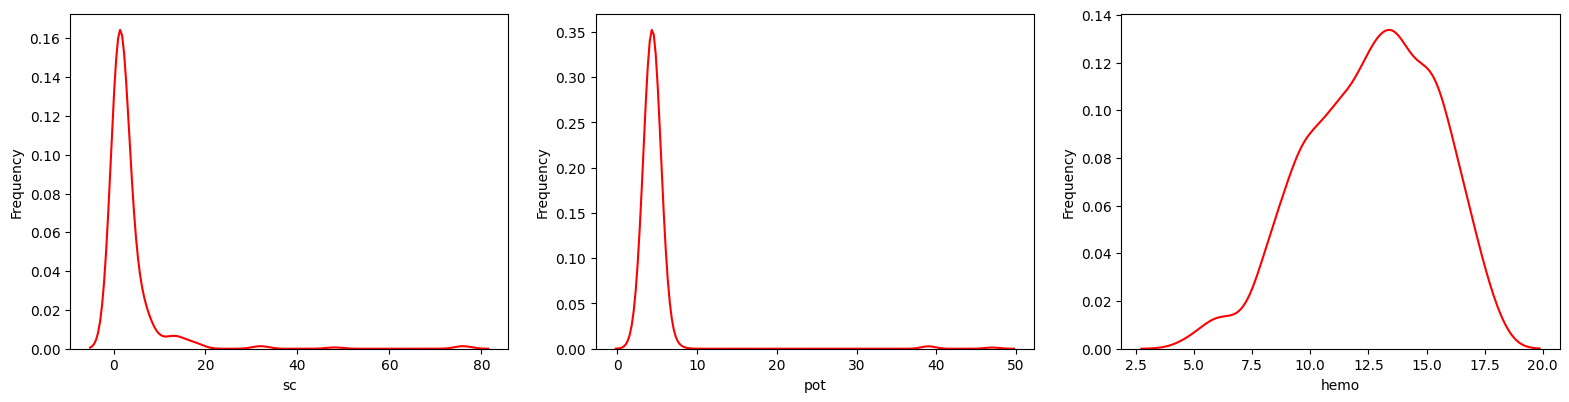

In [17]:
# 查看训练集数值变量分布
plt.figure(figsize=(26, 20))
i = 1
for col in Nu_feature:
    ax = plt.subplot(4, 4, i)
    ax = sns.kdeplot(df[col], color='red')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    i += 1
plt.show()

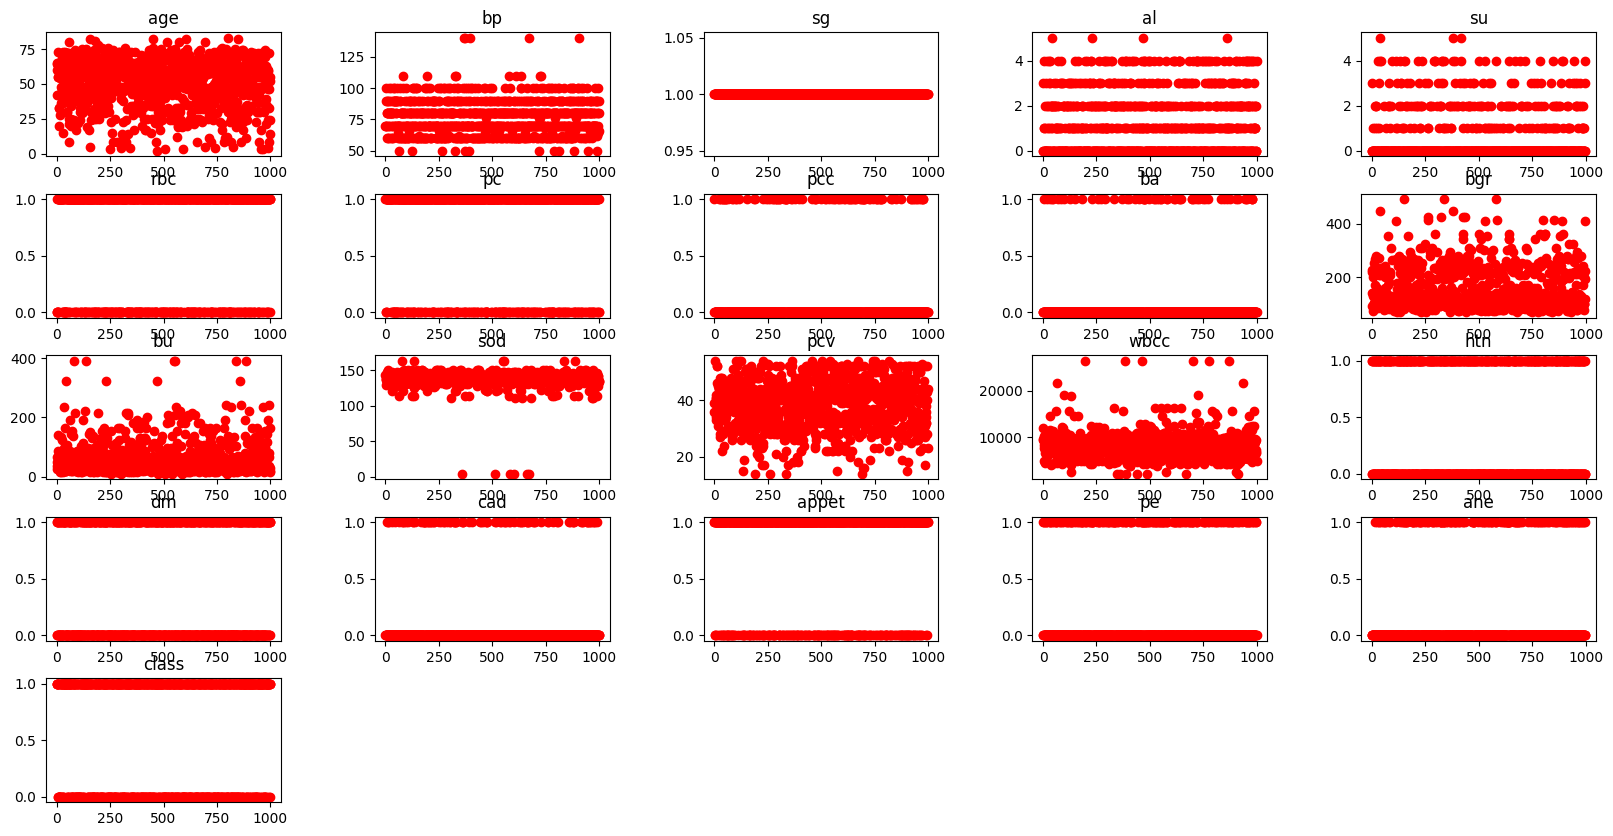

In [18]:
col1 = Ca_feature
plt.figure(figsize=(20, 10))
j = 1
for col in col1:
    plt.subplot(5, 5, j)
    ax = plt.scatter(x=range(len(df)), y=df[col], color='red')
    plt.title(col)
    j += 1

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()

In [19]:
df.dtypes

age        int64
bp         int64
sg         int64
al         int64
su         int64
rbc        int64
pc         int64
pcc        int64
ba         int64
bgr        int64
bu         int64
sc       float64
sod        int64
pot      float64
hemo     float64
pcv        int64
wbcc       int64
rbcc     float64
htn        int64
dm         int64
cad        int64
appet      int64
pe         int64
ane        int64
class      int64
dtype: object

In [20]:
float_cols = [col for col in df.columns if df[col].dtype == "float64"]

# 异常值检测以及处理

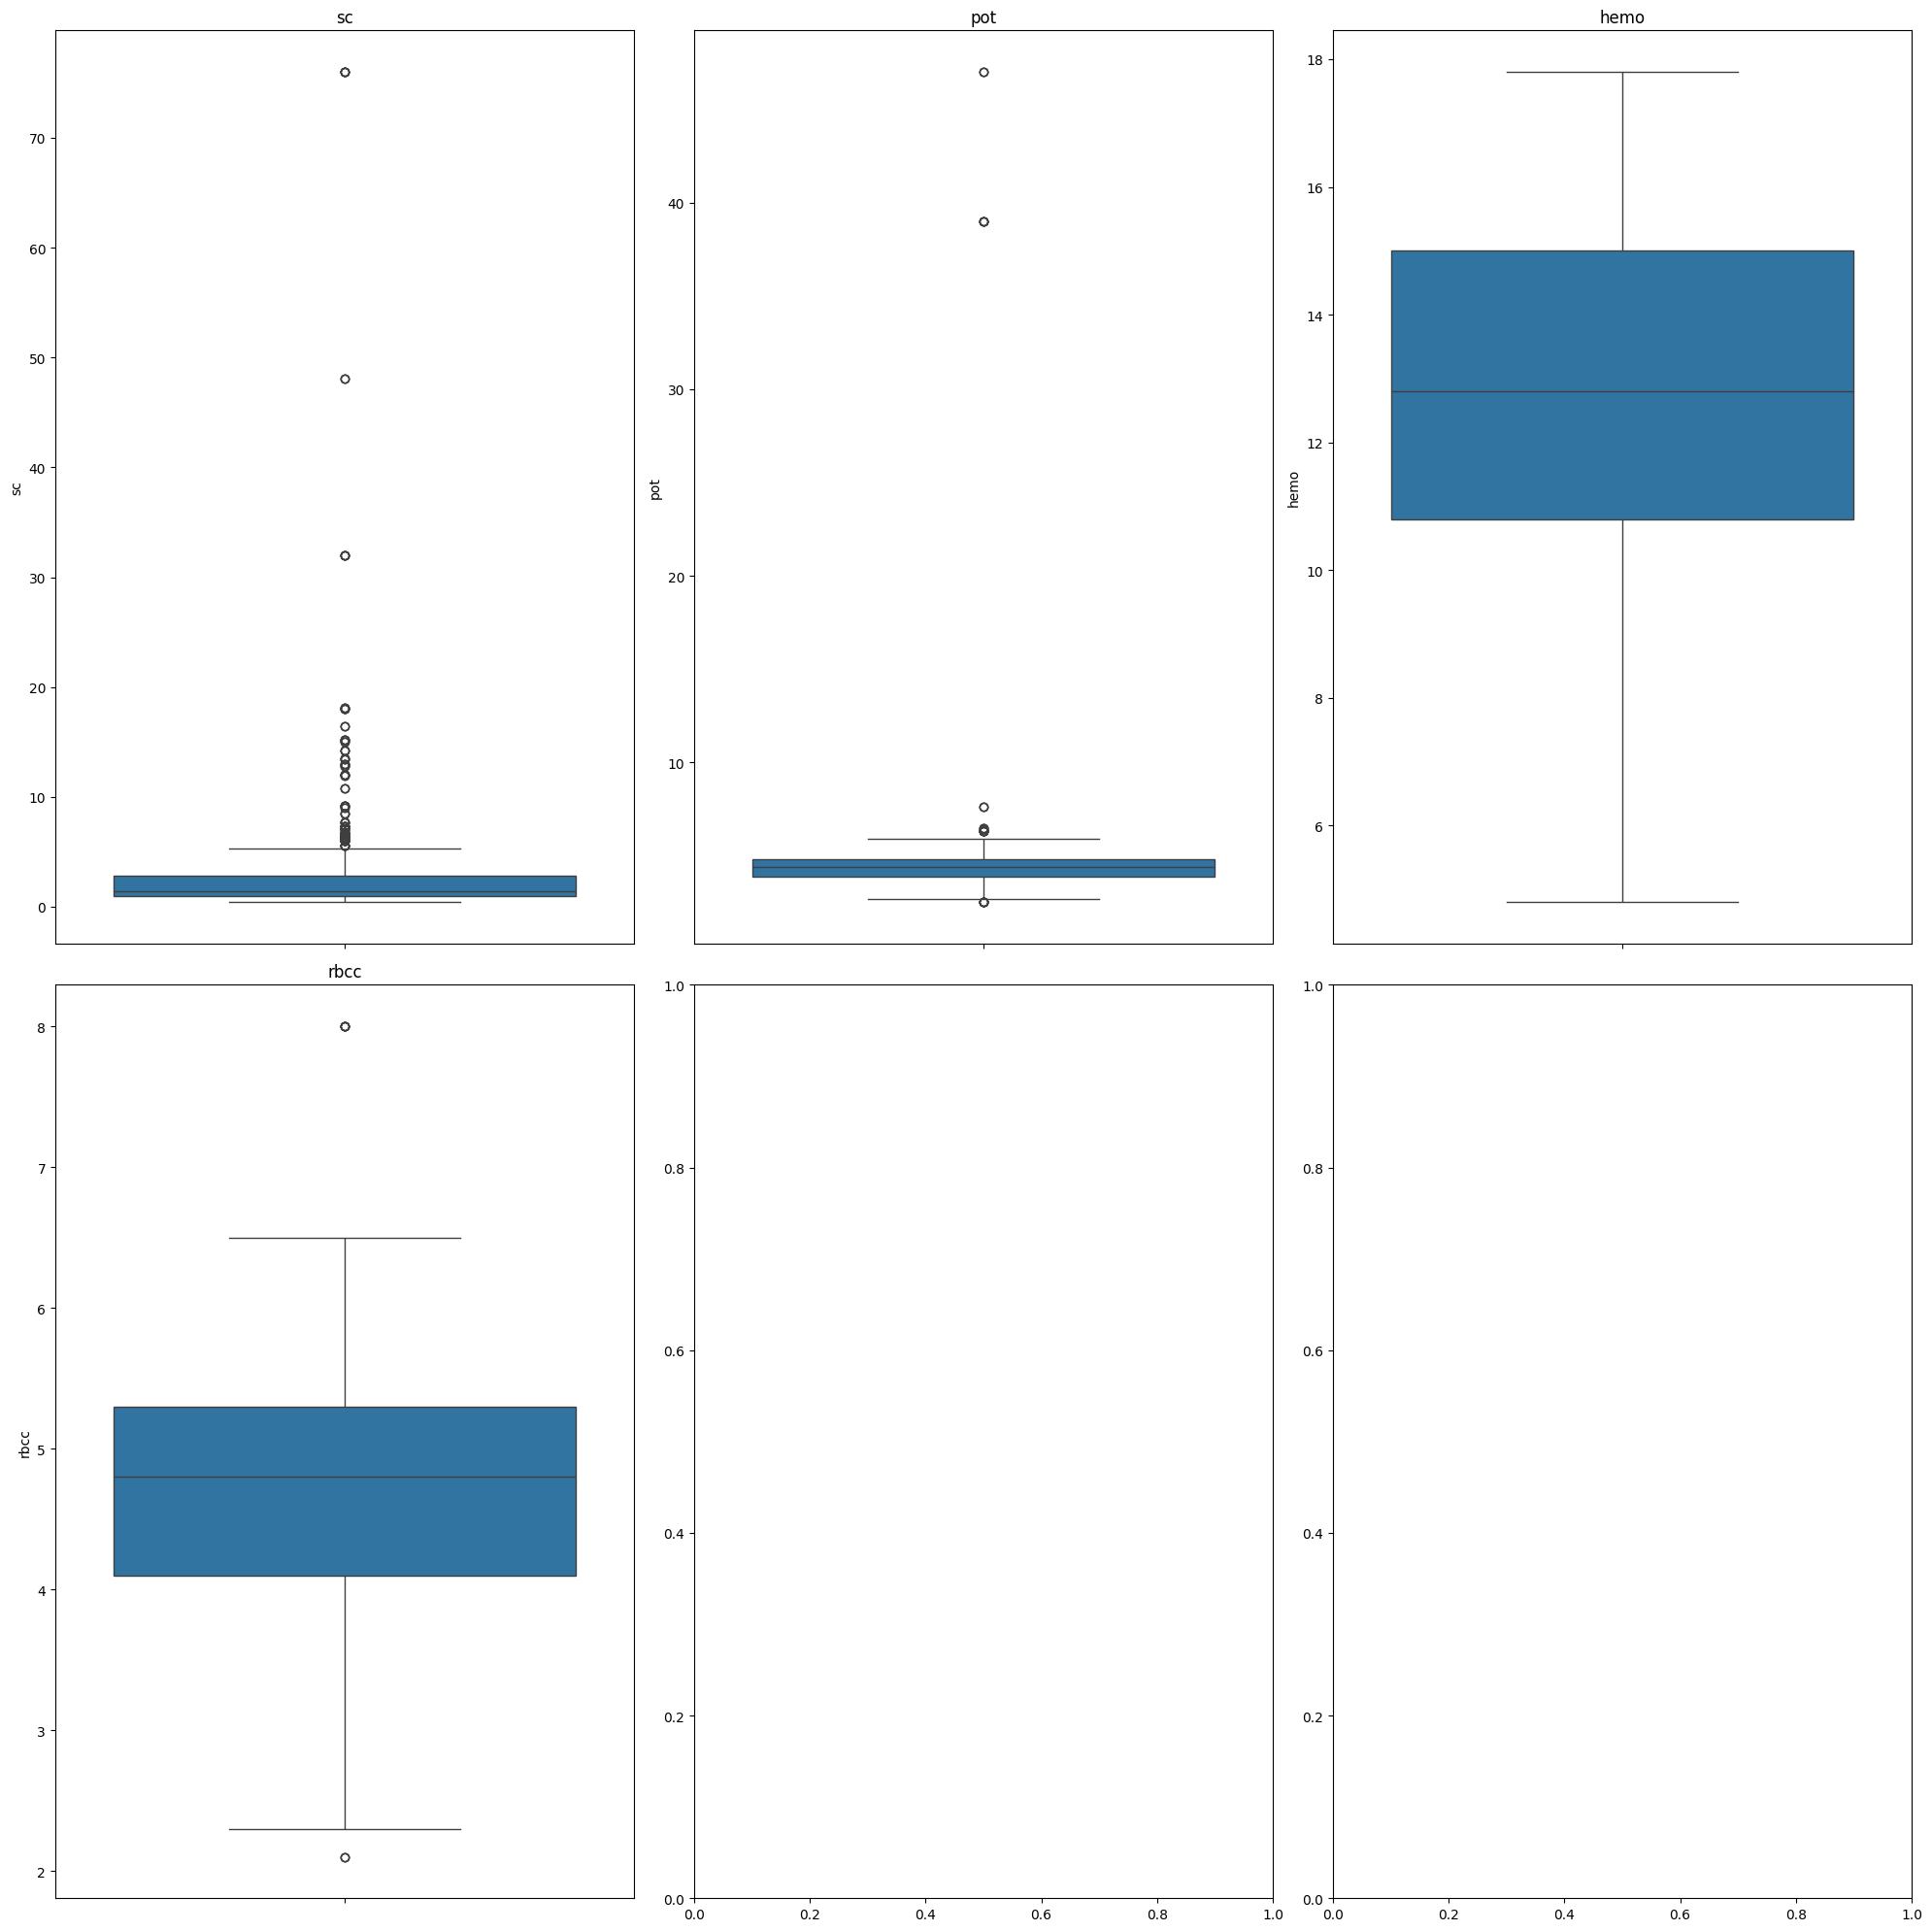

In [21]:
# 使用seaborn绘制多个特征的子图箱线图
# 这通常可以提供更美观的默认样式
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
for i, col in enumerate(float_cols):
    sns.boxplot(data=df[col], ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(col)
plt.tight_layout()
plt.show()

In [22]:
#hemo属性(血红蛋白)异常值的个数
outlier_count = 0
Q1 = df['hemo'].quantile(0.25)
Q3 = df['hemo'].quantile(0.75)
IQR = Q3 - Q1
outlier_count += ((df['hemo'] < Q1 - 1.5 * IQR) | (df['hemo'] > Q3 + 1.5 * IQR)).sum()

print("The number of outliers:", outlier_count)

The number of outliers: 0


In [23]:
#所有属性异常值的个数
outlier_count = 0
outlier_indices = []
for col in float_cols[2:]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count += ((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)).sum()
    outlier_indices.append(list(df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)].index))

outlier_indices = list(set(sum(outlier_indices, [])))
print("Number of outliers: ", len(outlier_indices))
print("Index of outliers: ", outlier_indices)

Number of outliers:  10
Index of outliers:  [290, 419, 903, 490, 402, 532, 405, 407, 26, 764]


In [24]:
df.dtypes

age        int64
bp         int64
sg         int64
al         int64
su         int64
rbc        int64
pc         int64
pcc        int64
ba         int64
bgr        int64
bu         int64
sc       float64
sod        int64
pot      float64
hemo     float64
pcv        int64
wbcc       int64
rbcc     float64
htn        int64
dm         int64
cad        int64
appet      int64
pe         int64
ane        int64
class      int64
dtype: object

In [25]:
# class 为1和为0两种情况下的异常值个数
p_counts = 0
n_counts = 0
for i in outlier_indices:
    if df['class'][i]==1:
        p_counts +=1
    else:
        n_counts +=1
print('Number of positive sample outliers:', p_counts)
print('The number of negative sample outliers:', n_counts)

Number of positive sample outliers: 10
The number of negative sample outliers: 0


In [26]:
# 删除异常值
for i in outlier_indices:
    # 删除索引的行
    df = df.drop(i)

df_reset = df.reset_index(drop=True)
print(df_reset)

     age   bp  sg  al  su  rbc  pc  pcc  ba  bgr  ...  pcv   wbcc  rbcc  htn  \
0     60   70   1   0   0    0   1    0   0  140  ...   39   9460   4.9    0   
1     64   90   1   3   3    0   0    1   0  229  ...   36   9720   4.5    1   
2     65   70   1   0   0    0   1    0   0   93  ...   36  11900   3.9    0   
3     42  100   1   4   0    1   0    0   1  220  ...   39   8300   4.6    1   
4     65   70   1   1   0    0   1    0   0  203  ...   36   5000   4.1    1   
..   ...  ...  ..  ..  ..  ...  ..  ...  ..  ...  ...  ...    ...   ...  ...   
985   33   80   1   0   0    1   1    0   0  100  ...   52   6700   6.0    0   
986   14   70   1   0   0    0   1    0   0  192  ...   40   9500   5.4    0   
987   55   80   1   0   0    1   1    0   0  118  ...   43   7200   5.4    0   
988   24   66   1   2   4    1   0    0   0  410  ...   44   6900   5.0    0   
989   52   90   1   4   3    1   0    0   0  224  ...   23   5000   2.9    1   

     dm  cad  appet  pe  ane  class  
0

In [27]:
df_reset = df.reset_index(drop=True)
print(df_reset)

     age   bp  sg  al  su  rbc  pc  pcc  ba  bgr  ...  pcv   wbcc  rbcc  htn  \
0     60   70   1   0   0    0   1    0   0  140  ...   39   9460   4.9    0   
1     64   90   1   3   3    0   0    1   0  229  ...   36   9720   4.5    1   
2     65   70   1   0   0    0   1    0   0   93  ...   36  11900   3.9    0   
3     42  100   1   4   0    1   0    0   1  220  ...   39   8300   4.6    1   
4     65   70   1   1   0    0   1    0   0  203  ...   36   5000   4.1    1   
..   ...  ...  ..  ..  ..  ...  ..  ...  ..  ...  ...  ...    ...   ...  ...   
985   33   80   1   0   0    1   1    0   0  100  ...   52   6700   6.0    0   
986   14   70   1   0   0    0   1    0   0  192  ...   40   9500   5.4    0   
987   55   80   1   0   0    1   1    0   0  118  ...   43   7200   5.4    0   
988   24   66   1   2   4    1   0    0   0  410  ...   44   6900   5.0    0   
989   52   90   1   4   3    1   0    0   0  224  ...   23   5000   2.9    1   

     dm  cad  appet  pe  ane  class  
0

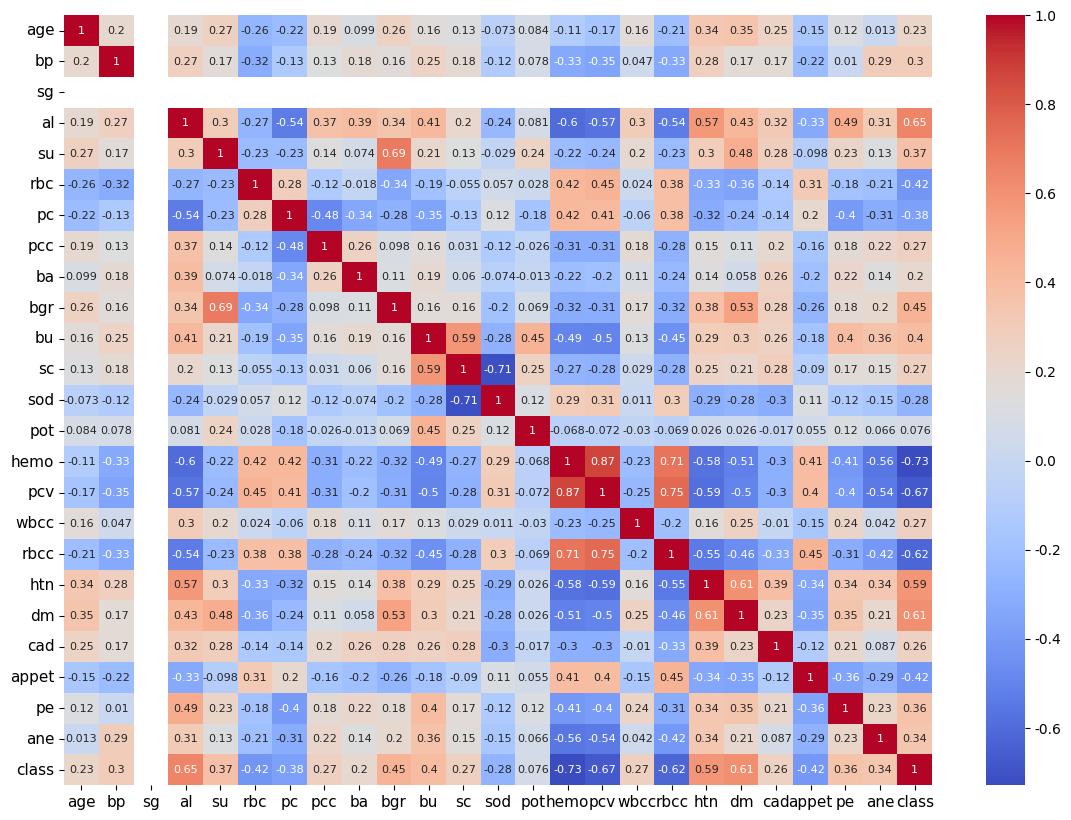

In [28]:
# 计算相关性矩阵并保留两位小数
plt.figure(figsize=(14, 10))
corr_matrix = df_reset.corr().round(3)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 8})
plt.yticks(size=11, rotation=0)
plt.xticks(size=11, rotation=0)
plt.show()

In [29]:
corr_matrix["class"]

age      0.226
bp       0.298
sg         NaN
al       0.650
su       0.372
rbc     -0.423
pc      -0.377
pcc      0.269
ba       0.202
bgr      0.449
bu       0.398
sc       0.268
sod     -0.275
pot      0.076
hemo    -0.729
pcv     -0.674
wbcc     0.270
rbcc    -0.622
htn      0.587
dm       0.614
cad      0.260
appet   -0.416
pe       0.360
ane      0.340
class    1.000
Name: class, dtype: float64

In [30]:
print(len(col1))
freq_dist = []
for k in range(len(col1)):
    freq_dist.append(f'freq_dist{i}')

21


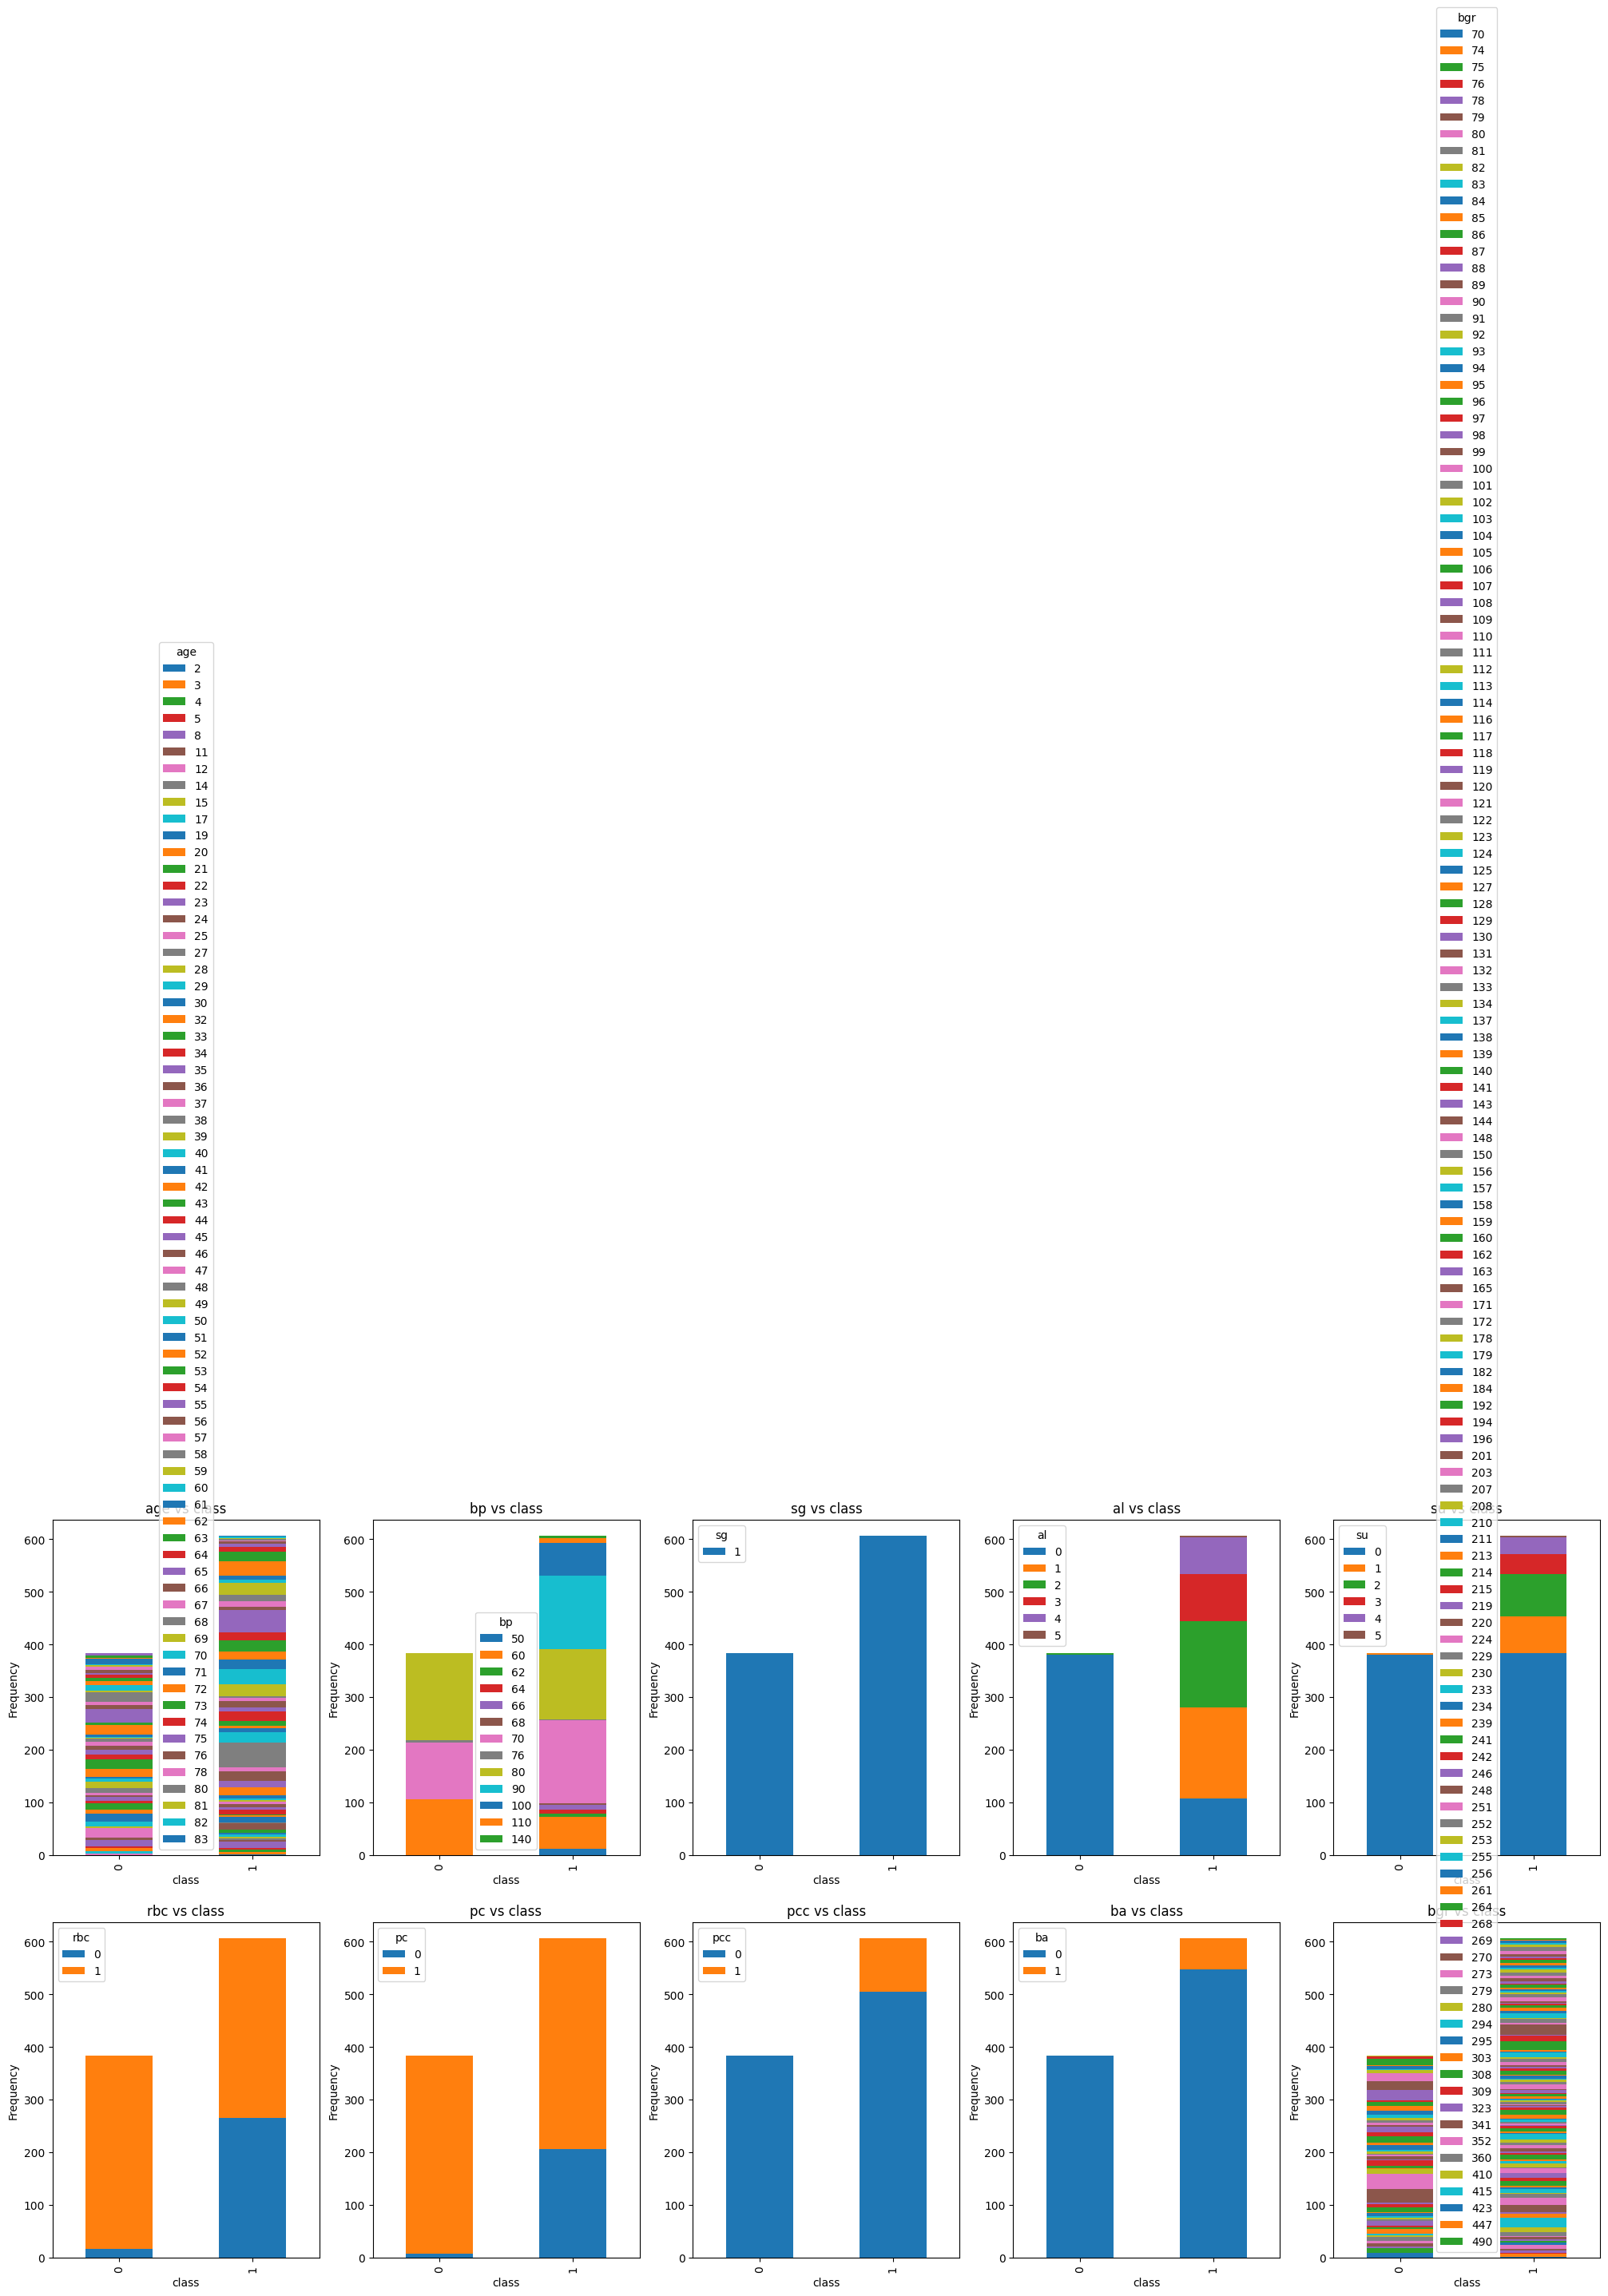

In [31]:
# 创建一个包含11个子图的画布
fig, axes = plt.subplots(2, 5, figsize=(25, 12))
for i in range(10):
    # 在每个子图中绘制堆叠条形图
    freq_dist[i] = df_reset.groupby(['class', col1[i]]).size().unstack()
    freq_dist[i].plot(kind='bar', stacked=True, ax=axes[i // 5, i % 5])
    axes[i // 5, i % 5].set_title(f'{col1[i]} vs class')
    axes[i // 5, i % 5].set_xlabel('class')
    axes[i // 5, i % 5].set_ylabel('Frequency')
# 显示图形
plt.show()

In [32]:
# 获取目标变量与其他变量的相关系数
correlations = corr_matrix['class'].abs().sort_values(ascending=False)

# 选择相关性较高的变量
top_factors = correlations[correlations > 0.38].index.tolist()
print("Main factors:", top_factors)
print("Number of factors:", len(top_factors))

Main factors: ['class', 'hemo', 'pcv', 'al', 'rbcc', 'dm', 'htn', 'bgr', 'rbc', 'appet', 'bu']
Number of factors: 11


In [33]:
# 设置随机种子
random_seed = 2024
random.seed(random_seed)
# 固定NumPy的随机种子
np.random.seed(random_seed)
# 固定Python的随机种子
sklearn.utils.check_random_state(random_seed)

RandomState(MT19937) at 0x15AC40140

In [34]:
y_train = df_reset.iloc[:, -1].to_numpy()
X_train = df_reset.iloc[:, :-1].to_numpy()

# 创建SVM分类器并进行训练
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)


SVC(kernel='linear')

In [35]:
import joblib
# 保存模型到磁盘
joblib.dump(svm, 'svm_model.pkl')


['svm_model.pkl']

In [36]:
# 创建PCA对象并进行降维
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
joblib.dump(pca, 'pca_model.pkl')

# 创建SVM分类器并进行训练
pca_svm = SVC(kernel='linear')
pca_svm.fit(X_train_pca, y_train)
joblib.dump(pca_svm, 'pca_svm_model.pkl')


['pca_svm_model.pkl']